# L1 and l2 Regularization

In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64
import tensorflow as tf

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

In [2]:
from sklearn.linear_model import LassoCV
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import train_test_split 

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
# Do not need zscore standardization for linear regression
#encode_numeric_zscore(df, 'horsepower')
#encode_numeric_zscore(df, 'weight')
#encode_numeric_zscore(df, 'cylinders')
#encode_numeric_zscore(df, 'displacement')
#encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45) 

/home/krishna/miniconda3/envs/NNDL/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [8]:
import seaborn as sns

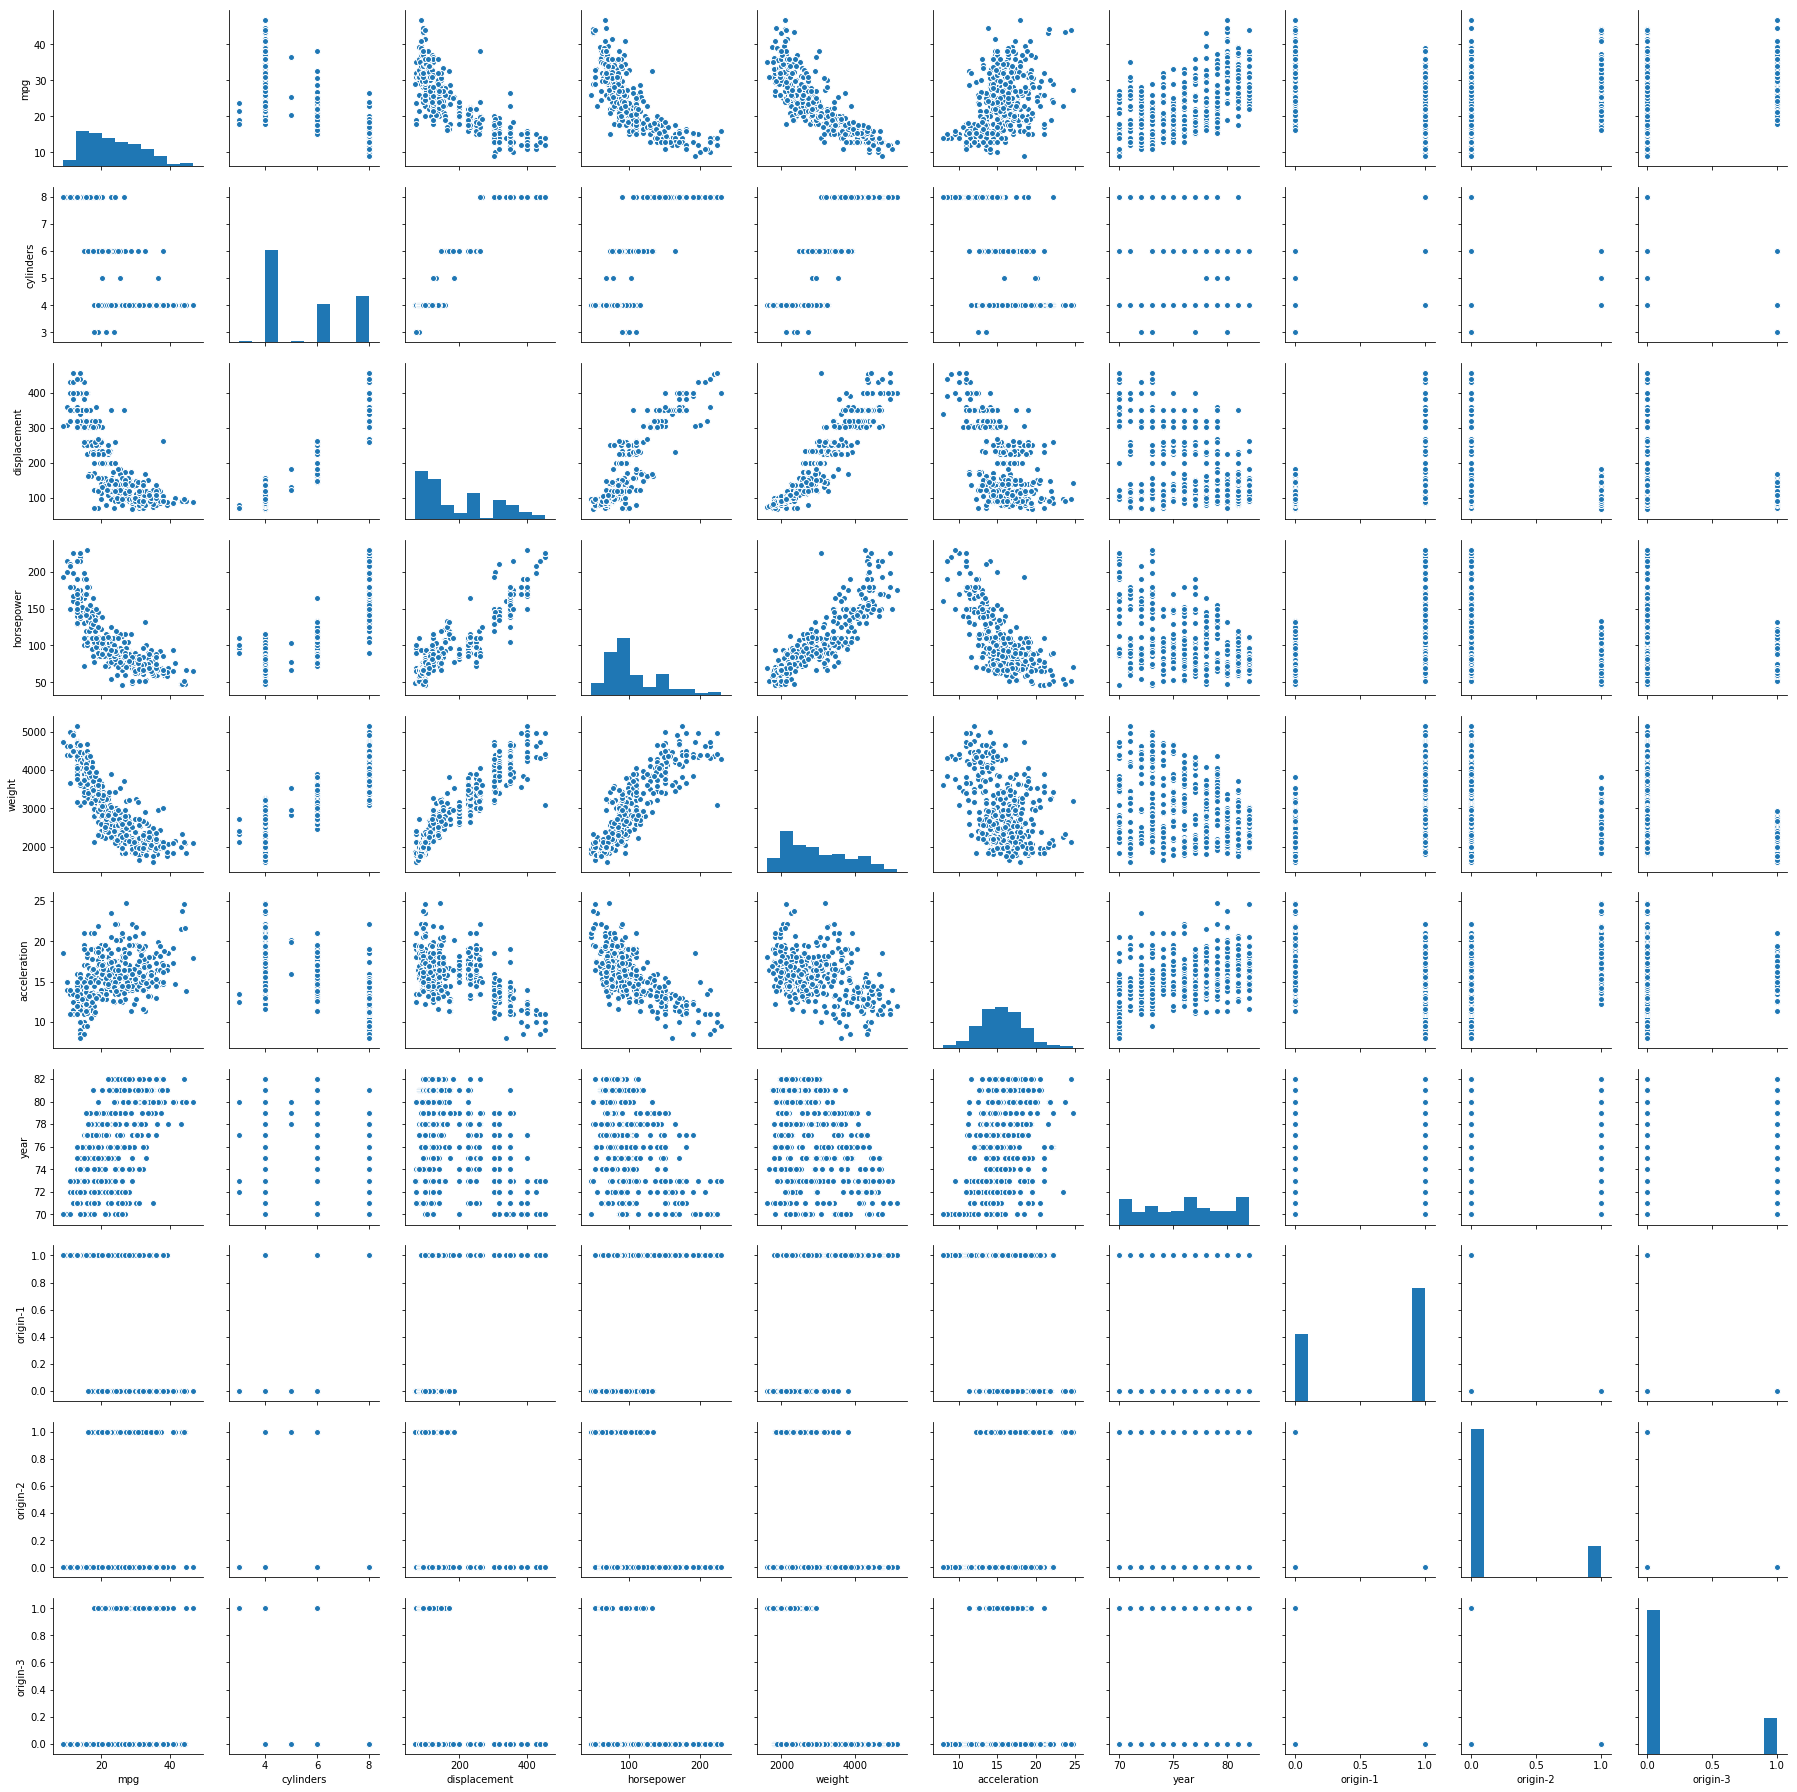

In [10]:
sns.pairplot(df)

- [x] Weight
- [x] Displacement
- [x] horsepower

these three are highly correlated

In [13]:
def report_coef(names,coef,intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))

final score. 2.9371566772460938


,coef,positive
origin-1,-1.448373,False
cylinders,-0.416550,False
horsepower,-0.007785,False
weight,-0.007473,False
displacement,0.024456,True
acceleration,0.138122,True
origin-3,0.629808,True
year,0.801274,True
origin-2,0.818565,True


Intercept: [-18.257532]


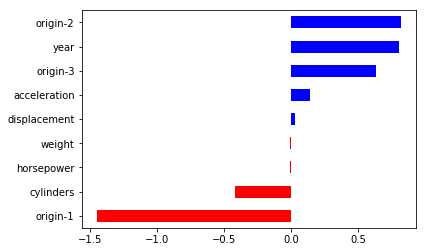

In [14]:
import sklearn 
regression = sklearn.linear_model.LinearRegression()
regression.fit(x_train, y_train)
pred = regression.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print ("final score. {}".format(score))
name = list(df.columns.values)
name.remove("mpg")
report_coef(
    name, 
    regression.coef_[0,:],
    regression.intercept_
)

In [74]:
df['displacement_2']= np.power(df['displacement'].values,-1.)
df['horsepower_2']= np.power(df['horsepower'].values,-1.)
df['weight_2']= np.power(df['weight'].values,-1.)

In [75]:
x,y = to_xy(df,'mpg')

x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45) 

/home/krishna/miniconda3/envs/NNDL/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


final score. 2.9631223678588867


,coef,positive
acceleration,-0.264461,False
cylinders,-0.225473,False
origin-1,-0.205122,False
origin-2,-0.095381,False
weight,-0.003765,False
displacement,-0.000433,False
horsepower,0.063144,True
origin-3,0.301908,True
year,0.764071,True
weight_2,11.739252,True


Intercept: [-39.498306]


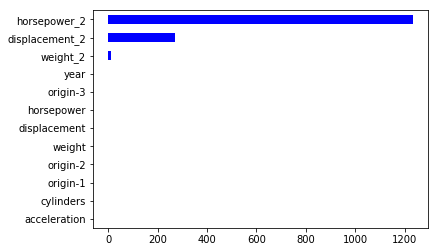

In [76]:
regression = sklearn.linear_model.LinearRegression()

regression.fit(x_train, y_train)
pred = regression.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print ("final score. {}".format(score))
name = list(df.columns.values)
name.remove("mpg")
report_coef(
    name, 
    regression.coef_[0,:],
    regression.intercept_
)

In [71]:
len(list(df.columns.values))

13

In [72]:
x_train.shape

(298, 12)

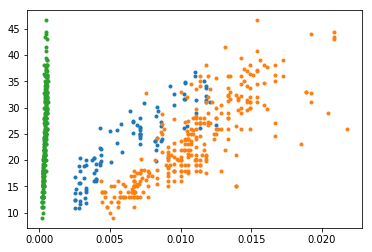

In [77]:
plt.plot(x_test[:,9], pred, ".")
plt.plot(x_train[:,10], y_train, ".")
plt.plot(x_train[:,11], y_train, ".")

# Lasso

L1 score. 3.040904998779297


,coef,positive
origin-1,-1.264473,False
weight,-0.007458,False
horsepower,-0.002797,False
cylinders,-0.000000,True
origin-2,0.000000,True
origin-3,0.000000,True
displacement_2,0.000000,True
horsepower_2,0.000000,True
weight_2,0.000000,True
displacement,0.013005,True


Intercept: [-17.27128]


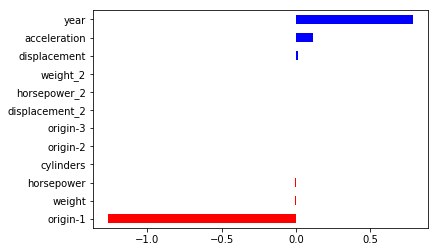

In [79]:
from sklearn.linear_model import Lasso
regressor = Lasso(random_state=0,alpha=.1)

regressor.fit(x_train, y_train)
pred = regressor.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("L1 score. {}".format(score))
names = list(df.columns.values)
names.remove("mpg")
report_coef( names,
           regressor.coef_, 
           regressor.intercept_)